In [1]:
# 0. import required packages

import numpy as numpy
import scipy as scipy
import matplotlib as matplotlib

In [2]:
# 1. load in audio waveform

from scipy.io import wavfile
samplerate, raw_data = wavfile.read('signal.wav')

print ("samplerate type: ", str(type(samplerate)), ", data type: ", str(type(raw_data)))
print ("sample rate: ", samplerate)
print ("data: ", raw_data)
print ("size: ", len(raw_data))

samplerate type:  <class 'int'> , data type:  <class 'numpy.ndarray'>
sample rate:  16000
data:  [ 174575  449637  316148 ... -315117 -454616 -419864]
size:  18091


In [3]:
# 2. DC subtraction (remove the mean of the signal)

mean = numpy.mean(raw_data)
print ("mean: ", mean)

mean_sub_data = raw_data - mean
print ("data: \n" , mean_sub_data)

mean:  11756.525786302582
data: 
 [ 162818.4742137  437880.4742137  304391.4742137 ... -326873.5257863
 -466372.5257863 -431620.5257863]


In [4]:
# 3. pre-emphasis filtering

def filter_data(data, b):
    filt_data = numpy.zeros(len(data))
    for n in range(len(data)):
        if n == 0:
            filt_data[n] = data[n]
        else:
            filt_data[n] = data[n] - (b * data[n - 1])
    return filt_data

b = 0.97
my_filt_data = filter_data(mean_sub_data, b)
print ("computed data: ", my_filt_data)

computed data:  [ 162818.4742137   279946.55422641 -120352.58577359 ... -137258.38577359
 -149305.20577359   20760.82422641]


In [5]:
# 4. transforming the audio into a sequence of frames

def compute_frames(x, L, S): # signal x, window length L, window shift S
    signal_size = len(x)
    frames_size = int(numpy.ceil(signal_size / S) - 2)
    frames = numpy.zeros([frames_size, L], dtype = float)

    for k in range(frames_size):
        for n in range(L):
            index = (k * S) + n
            # set frame value
            if (index < signal_size):
                frames[k, n] = x[index]
            # pad with zeros
            else:
                frames[k, n] = 0.000

    return frames

length = int(0.025 * samplerate)
shift = int(0.01 * samplerate)
print ("length: ", length, " shift: ", shift)

my_frames = compute_frames(my_filt_data, length, shift)
print ("computed frames: \n", my_frames)

length:  400  shift:  160
computed frames: 
 [[ 162818.4742137   279946.55422641 -120352.58577359 ...   74655.24422641
   -17433.40577359   55738.71422641]
 [ -38177.18577359   92239.03422641  121133.14422641 ...  194070.07422641
   -81543.88577359   -1369.36577359]
 [-171736.04577359   96426.77422641   66749.78422641 ...  152093.14422641
   -53729.15577359   83295.34422641]
 ...
 [-170056.87577359  -15541.18577359   58183.95422641 ...   54832.91422641
   -48280.95577359  157389.64422641]
 [ 125164.22422641  -86090.89577359  173169.64422641 ...  329577.10422641
    58099.77422641   16183.35422641]
 [ -16179.16577359 -229856.06577359   75007.57422641 ...       0.
        0.               0.        ]]


In [6]:
# 5. for each frame ...

from scipy import signal
from scipy import fft
import matplotlib.pyplot as plot

mel_filters = numpy.load("mel_filters.npy")

def compute_C_array(frame, N, C_array_size):
    # apply the window function
    window = signal.hamming(len(frame))
    windowed_frame = frame * window
    # compute the fourier transform
    X_m = fft.fft(windowed_frame, N)
    # compute magnitude
    X_m = numpy.abs(X_m)
    # square each element to get the power spectra
    X_m = X_m * X_m
    # # apply mel-filter
    X_m_half = X_m[0:mel_filters.shape[1]]
    #X_mel = numpy.matmul(X_m_half, mel_filters.T)
    # take the log
    X_log_mel = numpy.zeros(X_m_half.shape)
    for k in range(len(X_log_mel)):
        X_log_mel[k] = numpy.maximum(-50.0, numpy.log(X_m_half[k]))

    # compute the DCT and "liftering"
    C_array = numpy.zeros(C_array_size, dtype = float)
    for i in range(C_array_size):
        sum = 0.0
        for k in range(23):
            sum += X_log_mel[k] * numpy.cos(((numpy.pi * i) / 23) * (k + 0.5))
        C_array[i] = sum
        
    return C_array

N = 512
C = 13
MFCC_REP = numpy.zeros([len(my_frames), C], dtype = float)
for n in range(MFCC_REP.shape[0]):
    MFCC_REP[n] = compute_C_array(my_frames[n], N, C)

print ("MFCC_REP shape: ", MFCC_REP.shape)
print ("MFCC_REP: ", MFCC_REP)    

MFCC_REP shape:  (112, 13)
MFCC_REP:  [[ 5.87947739e+02  1.61062189e+01  8.53249480e+00 ...  5.30523234e+00
   1.28197470e+00  5.08627707e+00]
 [ 5.90166767e+02  1.69527104e+01  1.88127311e+01 ...  1.04437260e+01
  -2.56900790e+00 -6.38964202e+00]
 [ 5.93729009e+02  7.52491071e+00  4.28604981e+00 ...  8.54366482e+00
   1.75861656e+00  3.91664786e+00]
 ...
 [ 6.38554979e+02  3.06786706e+01  2.34669963e-01 ...  3.18657120e+00
  -3.80235818e+00 -6.74642971e-01]
 [ 6.51448920e+02  2.71937577e+01  4.21073278e+00 ...  3.65265806e-01
   8.59312610e+00  5.19979694e+00]
 [ 6.70345539e+02  3.43933544e+01  9.95780854e+00 ...  4.86442096e+00
   3.06963175e+00 -5.00810301e+00]]


mel_filters.shape:  (23, 257)


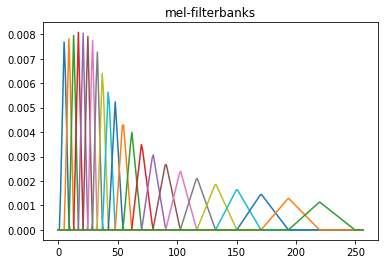

In [7]:
# mel filter plot
import matplotlib.pyplot as plot

mel_filters = numpy.load("mel_filters.npy")
print ("mel_filters.shape: ", mel_filters.shape)

plot.plot(mel_filters.T)
plot.title("mel-filterbanks")
plot.show()

ref_MFCC.shape:  (112, 13)
ref_MFCC:  [[ 5.39121421e+02 -1.88310069e+01  1.10734460e+00 ...  3.42458454e+00
   3.04125377e+00 -9.07008924e-01]
 [ 5.39289153e+02 -1.46975456e+01  2.91332735e+00 ...  1.68826014e+00
   2.82848659e+00  3.65086968e+00]
 [ 5.42237676e+02 -1.27343226e+01  3.82066903e+00 ...  1.84973034e+00
   5.42737464e+00  3.60466165e+00]
 ...
 [ 5.53221588e+02 -3.96558941e+00  1.15872326e+01 ...  6.99969974e-01
  -8.03559302e-01  1.78997048e+00]
 [ 6.33786166e+02 -3.31641578e+01 -6.26768414e+00 ...  1.50231180e+00
  -1.18006351e+00  1.42263382e+00]
 [ 6.41720883e+02 -3.18541353e+01 -4.99451925e+00 ...  8.15009283e-01
  -5.71254995e-01  2.26657194e+00]]


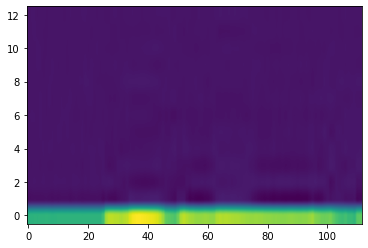

In [8]:
# get reference mfcc
ref_MFCC = numpy.load("reference_mfcc.npy")
print ("ref_MFCC.shape: ", ref_MFCC.shape)
print ("ref_MFCC: ", ref_MFCC)

plot.imshow(ref_MFCC.T, origin = 'lower', aspect = 'auto')

MFCC_REP shape:  (112, 4)


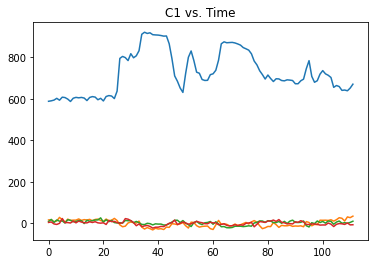

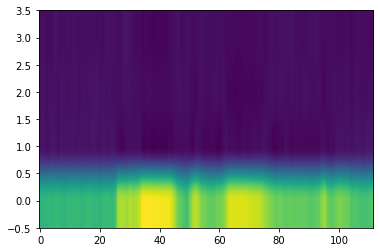

In [12]:
# all together now!

def compute_MFCC(wav, b, win_length, win_shift, N, C):
    # 1. load in wavefile
    samplerate, raw_data = wavfile.read(wav)
    # 2. DC subtraction (remove the mean of the signal)
    mean = numpy.mean(raw_data)
    mean_sub_data = raw_data - mean
    # 3. pre-emphasis filtering
    filt_data = filter_data(mean_sub_data, b)
    # 4. transform audio into a sequence of frames
    length = int(win_length * samplerate)
    shift = int(win_shift * samplerate)
    my_frames = compute_frames(filt_data, length, shift)
    # 5. calculate C array for each frame
    MFCC_REP = numpy.zeros([len(my_frames), C])
    for n in range(MFCC_REP.shape[0]):
        MFCC_REP[n] = compute_C_array(my_frames[n], N, C)
    return MFCC_REP


MFCC_REP = compute_MFCC('signal.wav', 0.97, 0.025, 0.01, 512, 4)
print ("MFCC_REP shape: ", MFCC_REP.shape)

plot.plot(MFCC_REP)
plot.title("C1 vs. Time")
plot.show()

plot.imshow(MFCC_REP.T, origin = 'lower', aspect = 'auto')

In [10]:
# Mean Squared Error (MSE) between the two matrices?

A = ref_MFCC
B = MFCC_REP

mse = (numpy.square(A - B)).mean(axis=None)
print ("Mean Square Error: ", mse)

Mean Square Error:  495554.02405478887
